<a href="https://colab.research.google.com/github/liuchihl/intro_ml_uci/blob/main/day_1/intro_to_ML_day_1_linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Linear Regression

In [29]:
# Load necessary packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
import seaborn as sns
import pandas as pd

# Configure plotting
rc('animation', html='jshtml')
qualitative_colors = ['#1b9e77','#d95f02','#7570b3','#e7298a']

# Set the random seed
rng = np.random.RandomState(1)

## 1.1 Load Diabetes Data





Throughout, we'll be using scikit-learn (sklearn), a popular open-source Python library for data analytics. It includes a wide range of algorithms for classification, regression, clustering, and dimensionality reduction.

In [30]:
from sklearn.datasets import load_diabetes

In [31]:
# Make the data set.
diabetes_bunch = load_diabetes()

print(diabetes_bunch.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

:Number of Instances: 442

:Number of Attributes: First 10 columns are numeric predictive values

:Target: Column 11 is a quantitative measure of disease progression one year after baseline

:Attribute Information:
    - age     age in years
    - sex
    - bmi     body mass index
    - bp      average blood pressure
    - s1      tc, total serum cholesterol
    - s2      ldl, low-density lipoproteins
    - s3      hdl, high-density lipoproteins
    - s4      tch, total cholesterol / HDL
    - s5      ltg, possibly log of serum triglycerides level
    - s6      glu, blood sugar level

Note: Each of these 10 feature variables have bee

In [32]:
# Load the dataset
X = diabetes_bunch.data
y = diabetes_bunch.target

# Standardize the targets:
y = (y - y.mean()) / y.std()

# Use only one feature: body mass index (BMI), standardized
X = X[:, np.newaxis, 2]
X = (X - X.mean()) / X.std()

# Split the data into training/testing sets
X_train = X[:-20]

X_test = X[-20:]

# Split the targets into training/testing sets
y_train = y[:-20]
y_test = y[-20:]

print(f"X_train: {X_train.shape}\nX_test:  {X_test.shape}")
print(f"y_train: {y_train.shape}\ny_test:  {y_test.shape}")

X_train: (422, 1)
X_test:  (20, 1)
y_train: (422,)
y_test:  (20,)


Text(0, 0.5, 'Disease Progression')

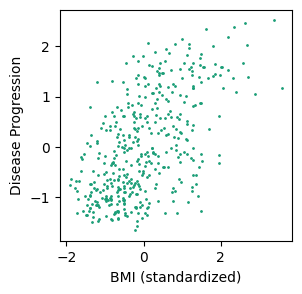

In [33]:
# Plot the dataset
fig, axs = plt.subplots(figsize=(3.,3.), nrows=1, ncols=1, facecolor='white', dpi=100)
axs.scatter(X_train, y_train, color=qualitative_colors[0], s=1)
axs.set_xlabel('BMI (standardized)')
axs.set_ylabel('Disease Progression')

## 1.2 Linear Regression

Given $n$ training points of the form $\{(x_i,y_i)\}_{i=1}^N$, where each $x_i$ is an **input** quantity and each $y_i$ is a **truth target**, or goal is to find a linear trend that best describes the data.

**Model**: A straight line $y = w_1 x + w_0$, where $w_0$ and $w_1$ are coefficients we aim to learn.

We use the letter $w$ because we think of the coefficients as **weights**; you should think about $y$ as a function of $x$ given the parameters $(w_0, w_1)$, i.e. $y=y(x|w_0,w_1)$.

**Linear Regression**: find the settings for $(w_0,w_1)$ that best fit the data.

How do we quantify best fit? We have to specify a **loss function** that tells us how well we matched our data. Our goal is to minimize the loss, closing the gap between the model's predictions and the truth targets.

One common loss function is the **squared-error** loss function, which quantifies the distance between the model's predictions $\widehat{y}_i = w_1x_i + w_0$ and the truth target $y_i$ as

\begin{align}
L(w_0, w_1)
  &= \sum_{i=1}^N (y_i - \widehat{y}_i)^2 \\
  &= \sum_{i=1}^{N} (y_i - (w_1 x_i + w_0))^2
\end{align}


In [34]:
def squarederror_loss(xs, ys, w0, w1):
  """Caculate the squared-error loss
    Parameters
    ----------
    xs : array_like
        x-axis values of data points, shape (number of data points)
    ys : array_like
        y-axis values of data points, shape (number of data points)
    w0 : array_like
        weight for intercept, shape (number of weights)
    w1 : array_like
        weight for slope, shape (number of weights)
    Returns
    -----------
    loss : array_like
        squared-error loss, shape (number of weights)
    """
  xs = np.asarray(xs).flatten()
  ys = np.asarray(ys).flatten()
  loss = np.sum((ys[:,np.newaxis] - (w1[np.newaxis,:] * xs[:,np.newaxis] + w0[np.newaxis,:]))**2.,axis=0)
  return loss

The squared-error loss function is minimized when the partial derivatives with respect to $ w_0 $ and $w_1 $ are zero:

$$\frac{\partial}{\partial w_0} \sum_{i=1}^{N} (y_i - (w_1 x_i + w_0))^2 = 0 $$

$$ \frac{\partial}{\partial w_1} \sum_{i=1}^{N} (y_i - (w_1 x_i + w_0))^2 = 0$$

These conditions produce for us the values of $w_0$ and $w_1$ that minimize the squared error loss,

\begin{align}
w_0 &= \frac{1}{N}\sum_{i=1}^N \big(y_i - w_1 x_i\big) \\
\end{align}


\begin{align}
w_1 &= \frac{\frac{1}{N} (\sum_{i=1}^N x_i y_i) - \bar{x} \bar{y}}{\frac{1}{N}(\sum_{i=1}^N x^2_i) - \bar{x}^2}
\end{align}

where here $\bar{x}$ and $\bar{y}$ are the averages of the $x_i$'s and $y_i$'s respectively.


In [35]:
def univariate_linear_regression(xs, ys):
  """Calculate optimal weights in the univariate linear regression case.
    Parameters
    ----------
    xs : array_like
        x-axis values of data points, shape (number of data points)
    ys : array_like
        y-axis values of data points, shape (number of data points)
    Returns
    -----------
    w0 : float
        weight for intercept
    w1 : float
        weight for slope
    """
  xs = np.asarray(xs).flatten()
  ys = np.asarray(ys).flatten()
  N = float(xs.shape[0])
  w1 = (np.sum(xs*ys)/N - np.mean(xs)*np.mean(ys) ) / ( np.sum(xs**2.)/N - np.mean(xs)**2.)
  w0 = (np.mean(ys) - w1*np.mean(xs))
  return w0, w1

In [36]:
# Calculate our analytic solutions
w0, w1 = univariate_linear_regression(X_train, y_train)
print(w0, w1)

0.01019894884982305 0.5795336900354175


Text(0, 0.5, 'Diabetes Progression')

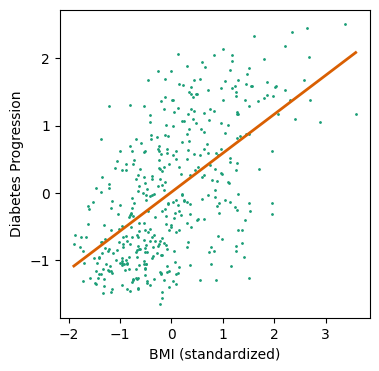

In [37]:
# Plot the data set with the linear regression fit
plot_xs = np.linspace(X_train.min(), X_train.max(), 101)
fig, axs = plt.subplots(figsize=(4.,4.), nrows=1, ncols=1, facecolor='white', dpi=100)
axs.scatter(X_train, y_train, s=1, color=qualitative_colors[0])
axs.plot(plot_xs, w1*plot_xs + w0, color=qualitative_colors[1], linewidth=2)
axs.set_xlabel('BMI (standardized)')
axs.set_ylabel('Diabetes Progression')

#### So, we've found the values of $(w_0, w_1)$ that minimize the loss function. How bad are other values? Let's make a grid of $(w_0, w_1)$ values, and then calculate the loss function at each point. This is typically called a **loss landscape**.

In [39]:
# Define a range of w0 and w1 values to calculate.
dw0, dw1 = 2, 2
w0_range = np.linspace(w0 - dw0, w0 + dw0, 200) # vary around 0.01
w1_range = np.linspace(w1 - dw1, w1 + dw1, 200) # vary around 12

# Make a 200 x 200 grids of w0 and w1 values over that range.
XX, YY = np.meshgrid(w0_range, w1_range)

# Flatten the grids to lists with 40000 values.
XY = np.c_[XX.ravel(), YY.ravel()]

In [40]:
# Calculate the squared-error loss for each pair of w0, w1 values.
Z = squarederror_loss(X_train, y_train, XY[:,0], XY[:,1])

# Turn the list of loss values into a 200 x 200 grid.
Z = Z.reshape(XX.shape)

# Also calculate the loss for the optimal w0, w1 values we found earlier.
best_fit_loss = squarederror_loss(X_train, y_train, np.array([w0]), np.array([w1]))[0]
print(f"Total Squared Error: {best_fit_loss:.4f}")
print(f"Mean Squared Error: {(best_fit_loss / len(X_train)):.4f}")

Total Squared Error: 281.4588
Mean Squared Error: 0.6670


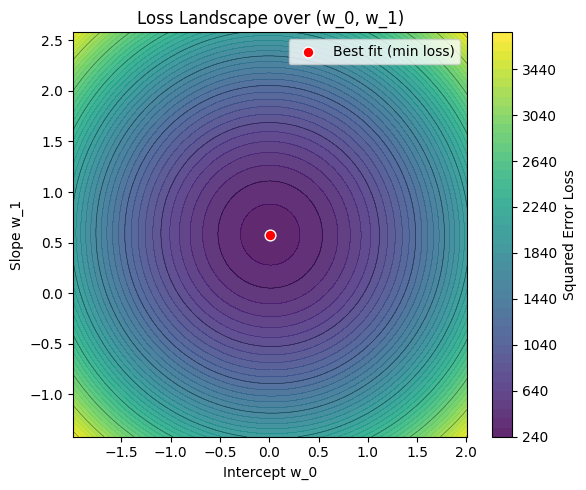

In [41]:
import matplotlib.pyplot as plt

# Loss Landscape Visualization
plt.figure(figsize=(6,5), dpi=100)

# Plot the loss surface as filled contours
contour = plt.contourf(
    XX, YY, Z,
    levels=50,
    cmap="viridis",
    alpha=0.85
)
cbar = plt.colorbar(contour, label="Squared Error Loss")

# Overlay contour lines
plt.contour(XX, YY, Z, levels=10, colors="k", alpha=0.4, linewidths=0.5)

# Mark the best-fit point
plt.scatter(w0, w1, color="red", edgecolor="white", s=60, label="Best fit (min loss)")

plt.title("Loss Landscape over (w_0, w_1)")
plt.xlabel("Intercept w_0")
plt.ylabel("Slope w_1")
plt.legend()
plt.tight_layout()
plt.show()

Clearly, the loss landscape has one unique minimum, the point we found via partial derivatives.

What if we had a more complicated loss landscape, so that we couldn't take partial derivatives?

This motivates our study of **gradient descent**, an iterative algorithm designed to search through a loss landscape for minima.

## 1.3 Gradient Descent

### Initialization

Our goal is to find our way to the settings of $(w_0,w_1)$ that minimize the loss function - the basin in the plot above.

We need to choose a starting point in the weight space - an initial guess for $w_0$ and $w_1$. This is called **initializing** the weights of the model.

A simple method to do this is to randomly choose a point, but this could be very far from the optimal position.

In linear regression, you'll have some intuition about your data, and can effectively eyeball where to start. In more complicated machine learning algorithms, initialization is more subtle, yet crucial to achieving stable training.

In [43]:
w0_init, w1_init = -0.2, 2

### Gradients

We've picked a starting point in our loss landscape. The goal is now to follow the **gradient** of the loss function, that is, the direction of steepest change. Since our goal is to find the loss minimum, we must climb against the gradient; hence, gradient descent.

The gradient at initialization has two components, one for each weight:

\begin{align}
\frac{\partial}{\partial w_0} \sum_{i=1}^{n} (y_i - (w_1 x_i + w_0))^2 &= -2 \sum_{i=1}^{n}(y_i - (w_1 x_i + w_0)) \\
\frac{\partial}{\partial w_1} \sum_{i=1}^{n} (y_i - (w_1 x_i + w_0))^2 &= -2 \sum_{i=1}^{n}(y_i - (w_1 x_i + w_0)) x_i
\end{align}

Remember here the value of the gradient assumes the initial values of $(w_1, w_0)$.


In [45]:
def gradient_of_weights(xs, ys, w0, w1):
  """Calculate the partial derivative of the loss function with respect to the weights.
  Parameters
  ----------
  xs : array_like
      x-axis values of data points, shape (number of data points)
  ys : array_like
      y-axis values of data points, shape (number of data points)
  w0 : float
    weight for intercept
  w1 : float
      weight for slope
  Returns
  -----------
  derivative_w0 : float
      partial derivative of the loss function with respect to theweight for slope
  derivative_w1 : float
      partial derivative of the loss function with respect to the weight for slope
  """

  derivative_w0 = np.sum((ys - (w1*xs + w0)) )
  derivative_w1 = np.sum((ys - (w1*xs + w0))*xs)

  return derivative_w0, derivative_w1

### Descent

#### Situated at our initial guess, we've got a gradient. We now need to take a step in the direction of the (negative) gradient. How big should that step be? Well, this turns out to be extremely important. In machine learning, the gradient step size is called the **learning rate**, and tuning the learning rate is absolutely crucial to training a performant model.

#### Let's call our learning rate $\eta$. Then, we can take a step of size $\eta$ in the direction of the gradient, to update the values of our weights:

\begin{align}
w_0 &← w_0 + \eta \sum_{i=1}^{n}(y_j - (w_1 x_i + w_0))
\\
w_1 &← w_1 + \eta \sum_{i=1}^{n}(y_j - (w_1 x_i + w_0)) x_i
\end{align}

To be clear, here's a nicely-packaged version of what we've done:

\begin{align}
  \mathbf{w} \leftarrow \mathbf{w} - \eta \nabla_{\mathbf{w}}L
\end{align}

where $\mathbf{w}:=(w_0, w_1)$ and $\nabla_\mathbf{w} L = (\frac{\partial L}{\partial w_0}, \frac{\partial L}{ \partial w_1})$. This is the gradient descent weight update.

In [ ]:
def update_weights(xs, ys, w0_old, w1_old, lr=1e-4):
  """ Update the weights using the partial derivate and step size.
  Parameters
  ----------
  xs : array_like
      x-axis values of data points, shape (number of data points)
  ys : array_like
      y-axis values of data points, shape (number of data points)
  w0_old : float
    weight for intercept
  w1_old : float
      weight for slope
  Returns
  -----------
  w0_new: float
    weight for intercept
  w1_new : float
    weight for slope
  """
  xs = np.asarray(xs).flatten()
  ys = np.asarray(ys).flatten()
  w0_new = w0_old + lr*np.sum((ys - (w1_old*xs + w0_old)) )
  w1_new = w1_old + lr*np.sum((ys - (w1_old*xs + w0_old))*xs)
  return w0_new, w1_new

In [ ]:
print(f"Analytic Minimum:    w0={w0:.3f}, w1={w1:.3f}")
print(f"Initialization:      w0={w0_init:.3f}, w1={w1_init:.3f}")


lr = 1e-4
w0_first, w1_first = update_weights(X_train, y_train, w0_init, w1_init, lr=lr)
print(f"After First GD Step: w0={w0_first:.3f}, w1={w1_first:.3f}")

> **EXERCISE 1**: What happens to the first update as you vary learning rate?

### Iteration

We need to just keep repeating this process until we're satisfied that our updated values $(w_0, w_1)$ have converged. We'll define convergence to be when the changes to our weights are sufficiently small, i.e. $\Delta w_0 = -\eta\times\partial L/\partial w_0< \delta_0$ and $\Delta w_1 = -\eta\times\partial L/\partial w_1 < \delta_1$ for some fixed thresholds $\delta_0,\delta_1$.

In [ ]:
def univariate_gradient_decent(xs, ys, w0_init, w1_init, lr = 0.001):
  """ Calculate the optimal weights using gradient descent.
  Parameters
  ----------
  xs : array_like
      x-axis values of data points, shape (number of data points)
  ys : array_like
      y-axis values of data points, shape (number of data points)
  w0_init : float
    initial guess of weight for intercept
  w1_init : float
    initial guess of weight for slope
  Returns
  -----------
  w0s: array_like
    list of weights for intercept
  w1s : array_like
    list of weights for slope
  """
  w0_firststep, w1_firststep = update_weights(xs, ys, w0_init, w1_init, lr=lr)

  w0s  = np.array( [w0_init, w0_firststep] )
  w1s  = np.array( [w1_init, w1_firststep] )

  while (np.abs(w0s[-2]-w0s[-1]) > 1e-8) or (np.abs(w1s[-2]-w1s[-1]) > 1e-8):
    w0_nextstep, w1_nextstep = update_weights(xs, ys, w0s[-1], w1s[-1], lr=lr)
    w0s = np.append(w0s, w0_nextstep)
    w1s = np.append(w1s, w1_nextstep)
  return w0s, w1s

In [ ]:
weights_to_plot0, weights_to_plot1 = univariate_gradient_decent(
    X_train, y_train, w0_init, w1_init, lr=10e-4
)
steps_0 = weights_to_plot0[1:] - weights_to_plot0[:-1]
steps_1 = weights_to_plot1[1:] - weights_to_plot1[:-1]

In [ ]:
weights_to_plot0.shape

In [ ]:
# Plot the squared-error loss values.
fig, axs = plt.subplots(figsize=(4.,4.), nrows=1, ncols=1, facecolor='white', dpi=100, sharex=True)
CS = axs.contour(XX, YY, Z)
axs.clabel(CS, inline=True, fontsize=10, fmt='%d')
axs.plot(weights_to_plot0, weights_to_plot1, '-', color='k')
axs.scatter(w0_init, w1_init, s=10, color='red')
axs.scatter(w0, w1, s=10, color='black')
axs.set_ylabel(r'$w_1$')
axs.set_xlabel(r'$w_0$')
axs.set_xlim(w0-dw0, w0+dw0)
axs.set_ylim(w1-dw1, w1+dw1)
axs.set_title("Loss Contours")
plt.show()

## 1.4 Fitting Multiple Features

Above is a very simple example, in just two dimensions, but it can extend to many dimensions. Let's fit the full dataset! We'll have to upgrade our notation a bit:

Our dataset is now $D := \{(\mathbf{x}_i, y_i)\}_{i=1}^N$ for input vectors $\mathbf{x}_i\in\mathbb{R}^{10}$. Our model is now a function of the data, given 11 parameters - one slope for each of the 10 input fields, and one for the intercept of the line. Collecting the slope parameters into a weight vector $\mathbf{w}:=(w_{10},w_9,...,w_1)$, our model is now

$$y_i(x_i|\mathbf{w}, w_0) = \mathbf{w}^T\mathbf{x}_i + w_0$$

where we can think about $\mathbf{w}$ as **weights** and $w_0$ as a **bias**. This terminology will pop up again when we study deep neural networks!

Note that the loss function is unchanged.

In [ ]:
# Load the full diabetes dataset
diabetes_dataset = load_diabetes(as_frame=True)

In [ ]:
sns.pairplot(diabetes_dataset.frame, corner=True)

In [ ]:
from sklearn.preprocessing import StandardScaler

features = diabetes_dataset.data
print(features.columns)

scaler = StandardScaler()
features = pd.DataFrame(scaler.fit_transform(features))
features.columns = diabetes_dataset.feature_names
print(f"\nInput Means:\n{features.mean(0)},\n\nInput Stds:\n{features.std(0)}")

targets = diabetes_dataset.target
targets = (targets - targets.mean()) / targets.std()
print(f"\nTargets:\nMean={targets.mean():.4f}, Std={targets.std():.4f}")

In [ ]:
from sklearn import linear_model

In [ ]:
reg = linear_model.LinearRegression()
reg.fit(features, targets)
print(features.columns)
print(reg.coef_)
print(reg.intercept_)

In [ ]:
reg = linear_model.SGDRegressor(loss='squared_error', max_iter=10000)
reg.fit(features, targets)
print(reg.coef_)
print(reg.intercept_)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y_pred = linear_model.LinearRegression().fit(features, targets).predict(features)

plt.figure(figsize=(5,5), dpi=100)
plt.scatter(targets, y_pred, alpha=0.7)
lims = [targets.min(), targets.max()]
plt.plot(lims, lims, 'r--', label='Ideal fit')
plt.xlabel("Actual target")
plt.ylabel("Predicted target")
plt.title("Predicted vs. Actual Diabetes Progression")
plt.legend()
plt.tight_layout()
plt.show()

One last point to make. When we study **linear** regression, we're talking a model that is linear with respect to its weights, not its inputs. For example, if we had a transformation $\phi(\mathbf{x})$, which may be some complicated (non-linear) function, we could still do linear regression like this:

$$
  y = \mathbf{w}^T\phi(\mathbf{x}) + w_0.
$$

This means linear regression can capture nonlinear relationships in the data — as long as those nonlinearities are expressed in the features.

> **EXERCISE 2**: Suppose we have a quadratic relationship between inputs $x_i$ and targets,
$$ y_i = 3x_i^2 + x_i. $$ Clearly, we won't do well if our model is $\widehat{y_i}=w_1x_i + w_0$. Can you think of another linear regression model that would do well?

# 2. Classification via Linear Decision Boundaries

Let's look at another canonical machine learning setting: classification! Our data takes the same form as it did for regression, i.e. vector inputs $\mathbf{x}_i$ and truth targets $y_i$, in full $D=\{(\mathbf{x}_i, y_i)\}_{i=1}^N$. The only difference is that our truth targets are binary (0 or 1) classification scores. This changes the nature of our task; instead of regressing continuous values, our goal is to draw a boundary that separates datapoints belonging to different classes. In this way, we will have partitioned, or classified, them.

## 2.0 Load Some Example Data

In [ ]:
from sklearn.datasets import make_classification

In [ ]:
# Make a synthetic dataset
X, labels = make_classification(n_features=2, n_redundant=0, n_informative=2, random_state=0, n_clusters_per_class=1, class_sep=3.)
X += 2 * rng.uniform(size=X.shape)

In [ ]:
# Plot the dataset
fig, axs = plt.subplots(figsize=(4.,4.), nrows=1, ncols=1, facecolor='white', dpi=100)
axs.scatter(X[:, 0], X[:, 1], marker="o", c=labels, s=25, edgecolor="k")
axs.set_xlabel('$x_1$')
axs.set_ylabel('$x_2$')

## 2.1 Decision Boundaries


A **decision boundary** is a line (or a hyperplane in more than two dimensions) that separates our classes.

Data that can be entirely separated by a line is called **linearly separable** data. What might this line look like? Well, the goal is to find a line relating $x_2$ and $x_1$, above which points of one class (say yellow points, class 1) belong, and below which points of the other class (say purple points, class 0) belong. We'll parametrize the line as

$ y(x)  = w_1 x + w_0 $

where as before, $w_0$ and $w_1$ are the parameters of the model, learnable weights.

In [ ]:
# Plot the data and with an initial guess for a decision boundary
plot_xs = np.linspace(X[:, 0].min(), X[:, 0].max(), 101)

w0_init, w1_init = -2., 2.

fig, axs = plt.subplots(figsize=(4.,4.), nrows=1, ncols=1, facecolor='white', dpi=100)
axs.scatter(X[:, 0], X[:, 1], marker="o", c=labels, s=25, edgecolor="k")
axs.plot(plot_xs, w1_init*plot_xs + w0_init, color='k', linewidth=2)
axs.set_xlabel('$x_1$')
axs.set_ylabel('$x_2$')


Obviously, though our data is linearly separable, we have totally failed to separate it.

Let's try to figure out how well we did. Our classification labels are generated by comparing our points to the decision boundary. This is done by checking the sign of the following quantity:

$$z := x_2 - y(x_1) = x_2 - (w_1 x_1 + w_0)$$

- Above the line, i.e. $z > 0$ --> label 1

- Below the line, i.e. $z < 0$ --> label 0

Given these criteria, we can now implement our predictions for the class of each point.

In [ ]:
def predict_class(x1s, x2s, w0, w1):
  """ Predict the class of each point.
  Parameters
  ----------
  x1s : array_like
      x-axis values of data points, shape (number of data points)
  x2s : array_like
      y-axis values of data points, shape (number of data points)
  w0 : float
    weight for intercept
  w1 : float
    weight for slope
  Returns
  -----------
  prediction: array_like
    list of predicted classes
  """
  prediction = np.asarray((x2s - (w1*x1s + w0)) > 0, dtype=int)
  return prediction

In [ ]:
predictions = predict_class(X[:, 0], X[:, 1], w0_init, w1_init)
print(predictions)
print(labels)
print(f"{np.sum(predictions == labels)} correct out of {labels.shape[0]} total")
print(f"{np.sum(predictions == labels) / labels.shape[0] * 100 :0.1f}% accuracy")

## 2.2 Classification with scikit-learn

Okay, instead of randomly guessing, we should train a classifier. We'll use a scikit-learn classifier that is trained via gradient descent. The goal is the same: find settings for $w_0$ and $w_1$ that minimize our loss function, which in this case is the **logistic loss** (sometimes called **binary cross entropy**, or **BCE**).

Before showing the explicit form of the loss function, recall that our deviation from the linear decision boundary was the quantity

$$ z := x_2 - w_1x_1 - w_0 $$

which is positive for class 1 and negative for class 0. We can squeeze this quantity into the range $[0,1]$, effectively producing a probability of $x_i$ corresponding to class 1, by applying the sigmoid function

$$\sigma(z) = \frac{1}{1 + e^{-z}}$$

so that when $z$ is increasingly positive, $\sigma(z)$ approaches 1, and when $z$ is increasingly negative, $\sigma(z)$ approaches 0.

> **EXERCISE 3**: Plot sigmoid as a function of $z$.


If we take our predictions to be probabilities $\widehat{y}_i = \sigma(z)$, we can compare them to the labels $y_i$ (either 0 or 1) with the BCE loss function

$$ L(w_0, w_1) = -\frac{1}{N}\sum_{i=1}^N \big(y_i\log \widehat{y}_i + (1-y_i)\log(1-\widehat{y}_i)\big)$$

Basically, we're looking at entropy scores that quantify the difference between our predicted probabilities and the target probabilities. The negative sign accounts for the fact that we're taking the log of probabilities, which are in the range $[0,1]$.


**Note**: In practice, the model learns one weight per input feature, i.e. a hyperplane $w_2x_2 + w_1x_1 + w_0$. This is an equivalent (just a reparametrization) to what is discussed here.

In [ ]:
from sklearn.linear_model import SGDClassifier

In [ ]:
clf = SGDClassifier(loss='log_loss', max_iter=100)
clf.fit(X, labels)

In [ ]:
fig, axs = plt.subplots(figsize=(4.,4.), nrows=1, ncols=1, facecolor='white', dpi=100)
axs.scatter(X[:, 0], X[:, 1], marker="o", c=labels, s=25, edgecolor="k")
axs.plot(plot_xs, (-(plot_xs * clf.coef_[0, 0]) - clf.intercept_[0]) / clf.coef_[0, 1], color='k', linewidth=2)
axs.set_xlabel('$x_1$')
axs.set_ylabel('$x_2$')

# 3. Unsupervised Clustering

The previous two methods we've examined have been **supervised**, in the sense that they look at data pairs $(x_i,y_i)$ with explicit training targets. What if you don't have access to training targets? This motivates the study of **unsupervised** methods. We'll look at several examples of **clustering** algorithms, that try to group similar datapoints without explicit labels.

## 3.1 The Breast Cancer Wisconsin Dataset

This dataset contains cell nuclei measurements of breast masses. Each sample represents one patient’s biopsy, with features describing the shape and texture of cell nuclei (e.g. *radius, perimeter, smoothness, compactness,* *concavity*). The target variable has two values: malignant (0) or benign (1). We're going to ignore these targets when creating our model, and only use them to evaluate its performance.

In [ ]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

data = load_breast_cancer(as_frame=True)
X = data.data
y = pd.Series(data.target, name="label")  # 0 = malignant, 1 = benign by default
y = (y==0).astype(int) # reverse the labels for clarity

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled.shape, y.value_counts()

## 3.2 K-Means Clustering

Given $N$ data points $\{\mathbf{x}_i\}_{i=1}^N$, our goal is to identify $K$ clusters (note: we have to specify $K$ up front). The algorithm is iterative with the following steps:

0. **Randomly generate centroids** for each cluster.

(Iterative steps)
1. **Assign each point** to the nearest centroid.
2. **Recompute** each centroid as the mean of all points assigned to it.
3. **Repeat** until assignments stabilize (convergence).

The algorithm (implicitly) minimizes the **within-cluster sum of squared distances** (the inertia). Given cluster centers $[\boldsymbol{\mu}_1, ..., \boldsymbol{\mu}_K]$, one vector location for each of the $K$ clusters, and cluster assignments $[z_1,...,z_N]$, one scalar for every data point, the inertia is

$$J=\sum_{i=1}^N ||\mathbf{x}_i - \boldsymbol{\mu}_{z_i}||^2$$

where:
- $C_k$ = indices of points in cluster $k$,
- $\boldsymbol{\mu}_k$ = mean (centroid) of those points.

The below cell runs $K$-Means on our data; note that $K$-Means is sensitive to initialization, and we ask for 20 different runs (with different initial centroid placements) below. The one with the lowest inertia is chosen.

In [ ]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, confusion_matrix

kmeans = KMeans(n_clusters=2, n_init=20, random_state=0)
labels_km = kmeans.fit_predict(X_scaled)
kmeans.inertia_

How well did we do? Well, it's kind of hard to visualize 30 dimensions. Instead, let's see if we can identify the 2 most relevant directions in this high dimensional space, so that we can plot them. This strategy is generically called **dimensionality reduction**

**Principal Component Analysis (PCA)** is a technique that captures key aspects of a high-dimensional dataset in lower dimensions. PCA identifies **principal components** in the data, which are directions in feature space where the data varies the most (directions of maximum variance). It builds a set of orthogonal **principle axes** along these directions (here we're shooting for 2), and returns the projection of the data onto the principle axes.

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=0)
Z = pca.fit_transform(X_scaled)

fig, axes = plt.subplots(1, 2, figsize=(9,4), dpi=100)

axes[0].scatter(Z[:,0], Z[:,1], c=y, cmap="coolwarm", s=14, alpha=0.8)
axes[0].set_title("True labels (Red=Malignant)")
axes[0].set_xlabel("PC1"); axes[0].set_ylabel("PC2"); axes[0].set_aspect("equal")

axes[1].scatter(Z[:,0], Z[:,1], c=labels_km, cmap="coolwarm", s=14, alpha=0.8)
axes[1].set_title("K-Means clusters (K=2)")
axes[1].set_xlabel("PC1"); axes[1].set_ylabel("PC2"); axes[1].set_aspect("equal")

plt.tight_layout()
plt.show()

Let's next evaluate how we did using a **confusion matrix**, which summarizes how a classification (or clustering) model’s predictions compare to the true labels.

|               | Predicted 0 | Predicted 1 |
|----------------|-------------|-------------|
| **True 0**     | True Negative (TN) | False Positive (FP) |
| **True 1**     | False Negative (FN) | True Positive (TP) |

From these four counts, we can compute key metrics:

$$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}, \quad
\text{Precision} = \frac{TP}{TP + FP}, \quad
\text{Recall} = \frac{TP}{TP + FN}
$$

In this sense, precision tells us how many malignancies were in our pool of predicted malignancies, and recall tells us what fraction of malignancies were correctly identified from all biopsies.

In [ ]:
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score
)
import numpy as np

# Compute classification metrics
precision = precision_score(y, labels_km)
recall = recall_score(y, labels_km)
f1 = f1_score(y, labels_km)
cm_km = confusion_matrix(y, labels_km, normalize="true")

# --- Print results ---
print(f"KMeans clustering evaluation:")
print(f"  Precision: {precision:.3f}")
print(f"  Recall:    {recall:.3f}")
print(f"  F1 Score:  {f1:.3f}")
print("  Normalized confusion matrix (rows = true labels):")
print(np.round(cm_km, 3))


## 3.3 DBSCAN

There are many drawbacks to K-means clustering. First, it is undesirable to have to specify $K$ up front. Also, $K$-means assums the data can be split up into localized "cells," which fails when the data is distributed as shown below.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def make_counterexample():
  # --- Generate disk (inner) and ring (outer shell) in 2D ---
  rng = np.random.default_rng(0)

  n_inner, n_shell = 300, 600
  r_inner = 1.0
  r_shell_in, r_shell_out = 1.5, 2.2

  # Uniform in disk: r ~ sqrt(U)*R, theta ~ Uniform(0, 2π)
  theta_i = rng.uniform(0, 2*np.pi, n_inner)
  r_i = r_inner * np.sqrt(rng.random(n_inner))
  Xi = np.c_[r_i * np.cos(theta_i), r_i * np.sin(theta_i)]

  # Uniform in annulus: r ~ sqrt(U*(R2^2 - R1^2) + R1^2)
  theta_o = rng.uniform(0, 2*np.pi, n_shell)
  u = rng.random(n_shell)
  r_o = np.sqrt(u*(r_shell_out**2 - r_shell_in**2) + r_shell_in**2)
  Xo = np.c_[r_o * np.cos(theta_o), r_o * np.sin(theta_o)]

  X = np.vstack([Xi, Xo])
  y = np.r_[np.zeros(n_inner, dtype=int), np.ones(n_shell, dtype=int)]  # 0=disk, 1=ring

  # --- K-Means with K=2 (shows the failure on non-convex clusters) ---
  kmeans = KMeans(n_clusters=2, n_init=10, random_state=0)
  labels = kmeans.fit_predict(X)
  centers = kmeans.cluster_centers_

  # --- Plot: ground truth vs K-Means assignment ---
  fig, axes = plt.subplots(1, 2, figsize=(8, 4), dpi=100)
  axes[0].scatter(X[:,0], X[:,1], c=y, s=12, alpha=0.8, cmap="viridis")
  axes[0].set_title("Ground truth: disk (0) vs ring (1)")
  axes[0].set_aspect("equal")
  axes[0].axis("off")

  axes[1].scatter(X[:,0], X[:,1], c=labels, s=12, alpha=0.8, cmap="viridis")
  axes[1].scatter(centers[:,0], centers[:,1], marker="X", s=140, c="red", edgecolor="k", label="Centroids")
  axes[1].set_title("K-Means (K=2): splits by proximity")
  axes[1].set_aspect("equal")
  axes[1].axis("off")
  axes[1].legend(loc="lower left", frameon=False)

  plt.tight_layout()
  plt.show()

make_counterexample()

Unlike K-Means, which assumes roughly spherical clusters and requires choosing $K$ ahead of time,
**DBSCAN (Density-Based Spatial Clustering of Applications with Noise)** finds clusters
based on *regions of high density*.

It builds clusters iteratively based on two parameters:
- **ε (epsilon):** the neighborhood radius around each point
- **min_samples:** the minimum number of neighbors required to form a dense region

Algorithm outline:
1. Pick an unvisited point.
2. If it has at least `min_samples` points within distance `ε`, start a new cluster.
3. Recursively include all density-connected points.
4. Points not belonging to any cluster are labeled as **noise** (`-1`).

DBSCAN can find arbitrarily shaped clusters and automatically ignores outliers,
making it powerful for physical-science data where signal and noise differ by density.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.cluster import KMeans, DBSCAN

# --- helper: generate "galaxy clusters over dense background of stars" ---
def make_galaxy_clusters(random_state=0):
    rng = np.random.default_rng(random_state)
    # three compact Gaussian "galaxy" clusters
    c1 = rng.normal([0.0, 0.0], [0.15, 0.15], size=(500, 2))
    c2 = rng.normal([2.0, 1.0], [0.20, 0.12], size=(450, 2))
    c3 = rng.normal([-1.7, 1.8], [0.18, 0.18], size=(400, 2))
    # dense uniform background "field stars"
    bg = rng.uniform(-3.0, 3.0, size=(800, 2))
    X = np.vstack([c1, c2, c3, bg])
    return X

# --- build both datasets ---
X_moons, _ = make_moons(n_samples=800, noise=0.05, random_state=42)
X_galaxy = make_galaxy_clusters(random_state=0)

# --- choose DBSCAN params per dataset (tuned for these scales) ---
db_params = {
    "moons": dict(eps=0.2, min_samples=5),
    "galaxy": dict(eps=0.15, min_samples=10),
}

# --- fit clusterers ---
km_moons = KMeans(n_clusters=2, n_init=10, random_state=0).fit(X_moons)
db_moons = DBSCAN(**db_params["moons"]).fit(X_moons)

km_gal = KMeans(n_clusters=4, n_init=10, random_state=0).fit(X_galaxy)   # KMeans guesses a K; 4 works reasonably here
db_gal = DBSCAN(**db_params["galaxy"]).fit(X_galaxy)

# --- plot: 2 rows (Moons, Galaxy), 2 cols (KMeans, DBSCAN) ---
fig, ax = plt.subplots(2, 2, figsize=(9, 8), dpi=100)

# Row 1: Two Moons
ax[0, 0].scatter(X_moons[:, 0], X_moons[:, 1], c=km_moons.labels_, cmap="tab10", s=12)
ax[0, 0].set_title("K-Means (Two Moons)")
ax[0, 1].scatter(X_moons[:, 0], X_moons[:, 1], c=db_moons.labels_, cmap="tab10", s=12)
ax[0, 1].set_title("DBSCAN (Two Moons)")

# Row 2: Galaxy clusters + dense background
ax[1, 0].scatter(X_galaxy[:, 0], X_galaxy[:, 1], c=km_gal.labels_, cmap="tab10", s=8)
ax[1, 0].set_title("K-Means (Galaxy clusters + background)")
# Color noise (-1) as light gray for clarity
labels = db_gal.labels_.copy()
colors = np.where(labels == -1, -1, labels)
mask = labels >= 0
ax[1, 1].scatter(X_galaxy[:, 0][mask], X_galaxy[:, 1][mask],
                 c=labels[mask], cmap="tab10", s=8)
# Overlay noise points explicitly
ax[1, 1].scatter(X_galaxy[labels==-1, 0], X_galaxy[labels==-1, 1],
                 c="lightgray", s=6, label="Noise")
ax[1, 1].set_title("DBSCAN (Galaxy clusters + background)")
ax[1, 1].legend(loc="lower left", fontsize=8, frameon=False)

# aesthetics
for i in range(2):
    for j in range(2):
        ax[i, j].set_aspect("equal")
        ax[i, j].axis("off")

plt.tight_layout()
plt.show()

# Notes:

> **EXERCISE 4**: What happens if you change `eps` and `min_samples` above? Try out your strategy on `X_galaxy`.

# Solutions to Exercises

### Exercise 1
 You should notice that only small-ish values of the learning rate produce reasonably-sized updates to w_0. As lr grows, you jump over the minimum!

### Exercise 2

Just take $\widehat{y_i} = w_2 x_i^2 + w_1 x_i + w_0$, where we simply treat $x_i$ and $x_i^2$ as two separate inputs.

### Exercise 3

```
z = np.linspace(-10, 10, 1000)
sigmoid = lambda x: 1/(1 + np.exp(-x))
fig = plt.figure(figsize=(3,3), dpi=100)
plt.plot(z, sigmoid(z), 'b-')
plt.xlabel(r"$z$")
plt.ylabel(r"$\sigma(z)$")
plt.show()
```

### Exercise 4
```
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

def kth_neighbor_distances(X, k, metric="euclidean", algorithm="auto"):
    """
    Return the sorted distances to each point's k-th nearest neighbor.
    Note: we ask for k+1 neighbors because the closest neighbor is the point itself (distance 0).
    """
    nn = NearestNeighbors(n_neighbors=k+1, metric=metric, algorithm=algorithm)
    nn.fit(X)
    dists, _ = nn.kneighbors(X)
    kth = dists[:, k]              # distance to the k-th neighbor (excluding self)
    return np.sort(kth)            # sort for elbow visualization

k = 10  # this is our guess for min_samples
kth_sorted = kth_neighbor_distances(X_galaxy, k=k)

plt.figure()
plt.plot(np.arange(len(kth_sorted)), kth_sorted, lw=2)
plt.xlabel("Points sorted by k-distance")
plt.ylabel(f"Distance to {k}-th nearest neighbor")
plt.title(f"k-distance plot (k={k})")
plt.grid(alpha=0.3)
plt.show()
```